In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

import torchvision.datasets as dsets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import os
os.chdir('/Users/dengyi/Desktop/program_instances/pytorch_practice')

In [2]:
image_size = 28
num_classes = 10
num_epoches = 20
batch_size = 64

In [3]:
train_dataset = dsets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [4]:
indices = range(len(test_dataset))
indices_val = indices[:5000]
indices_test = indices[5000:]

In [5]:
sampler_val = torch.utils.data.sampler.SubsetRandomSampler(indices_val)
sampler_test = torch.utils.data.sampler.SubsetRandomSampler(indices_test)

validation_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, sampler=sampler_val)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, sampler=sampler_test)

标签是： 5


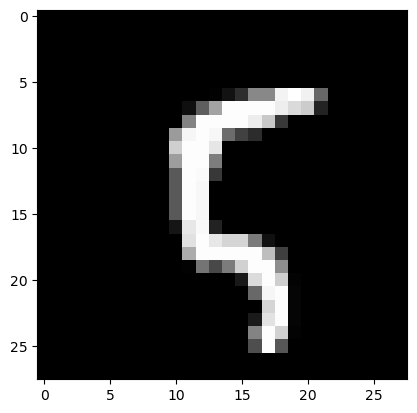

In [6]:
idx = 100
muteimg = train_dataset[idx][0].numpy()

plt.imshow(muteimg[0,...], cmap='gray')
print('标签是：', train_dataset[idx][1])

In [7]:
depth = [4, 8]
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(depth[0], depth[1], 5, padding=2)
        self.fc1 = nn.Linear(image_size//4*image_size//4*depth[1], 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, image_size//4*image_size//4*depth[1])
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

    def retrieve_features(self, x):
        feature_map1 = F.relu(self.conv1(x))
        x = self.pool(feature_map1)
        feature_map2 = F.relu(self.conv2(x))
        return (feature_map1, feature_map2)

In [8]:
def rightness(predictions, labels):
    pred = torch.max(predictions.data, 1)[1]
    rights = pred.eq(labels.data.view_as(pred)).sum()
    return rights, len(labels)

In [9]:
net = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [10]:
def train_model(data, target):
    net.train()
    output = net(data)
    loss = criterion(output, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    right = rightness(output, target)
    return right, loss

In [11]:
def evaluate_model():
    net.eval()
    val_rights = []
    for (data, target) in validation_loader:
        data, target = Variable(data), Variable(target)
        output = net(data)
        right = rightness(output, target)
        val_rights.append(right)
    
    return val_rights

In [12]:
record = []
weights = []

for epoch in range(num_epoches):
    train_rights = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        right, loss = train_model(data, target)
        train_rights.append(right)

        if batch_idx % 100 == 0:
            val_rights = evaluate_model()
            val_r = (sum([tup[0] for tup in val_rights]), sum([tup[1] for tup in val_rights]))

            train_r = (sum([tup[0] for tup in train_rights]), sum([tup[1] for tup in train_rights]))

            print('训练周期：{} [{}/{}({:.0f}%)]\tLoss: {:.6f}\t训练正确率：{:.2f}%\t校验正确率：{:.2f}%'.format(
                epoch, batch_idx*batch_size, len(train_loader.dataset), 100.*batch_idx/len(train_loader), loss.data,
                100.*train_r[0].numpy()/train_r[1], 100.*val_r[0].numpy()/val_r[1]
            ))
            record.append((100-100.*train_r[0]/train_r[1], 100-100.*val_r[0]/val_r[1]))

            weights.append([net.conv1.weight.data.clone(), net.conv1.bias.data.clone(),
                            net.conv2.weight.data.clone(), net.conv2.bias.data.clone()])
      

训练周期：0 [0/60000(0%)]	Loss: 2.296630	训练正确率：10.94%	校验正确率：10.16%
训练周期：0 [6400/60000(11%)]	Loss: 2.301968	训练正确率：10.35%	校验正确率：10.02%
训练周期：0 [12800/60000(21%)]	Loss: 2.299085	训练正确率：10.55%	校验正确率：14.14%
训练周期：0 [19200/60000(32%)]	Loss: 2.301116	训练正确率：11.06%	校验正确率：11.52%
训练周期：0 [25600/60000(43%)]	Loss: 2.301251	训练正确率：11.71%	校验正确率：11.52%
训练周期：0 [32000/60000(53%)]	Loss: 2.291829	训练正确率：12.06%	校验正确率：11.42%
训练周期：0 [38400/60000(64%)]	Loss: 2.293775	训练正确率：12.24%	校验正确率：11.44%
训练周期：0 [44800/60000(75%)]	Loss: 2.298847	训练正确率：12.43%	校验正确率：11.42%
训练周期：0 [51200/60000(85%)]	Loss: 2.306074	训练正确率：12.31%	校验正确率：11.42%
训练周期：0 [57600/60000(96%)]	Loss: 2.292087	训练正确率：12.34%	校验正确率：11.42%
训练周期：1 [0/60000(0%)]	Loss: 2.290462	训练正确率：20.31%	校验正确率：11.44%
训练周期：1 [6400/60000(11%)]	Loss: 2.270902	训练正确率：13.03%	校验正确率：11.46%
训练周期：1 [12800/60000(21%)]	Loss: 2.292351	训练正确率：14.20%	校验正确率：11.84%
训练周期：1 [19200/60000(32%)]	Loss: 2.283882	训练正确率：15.48%	校验正确率：17.70%
训练周期：1 [25600/60000(43%)]	Loss: 2.262953	训练正确率：17.55%	校验正确率：23.38%
训练周期：1 

Text(0, 0.5, 'Error Rate')

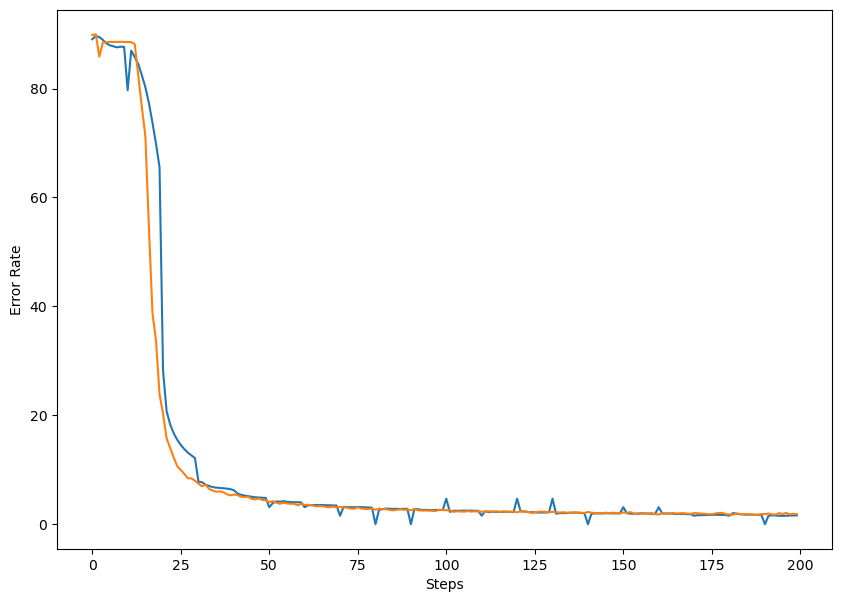

In [13]:
plt.figure(figsize=(10, 7))
plt.plot(record)
plt.xlabel('Steps')
plt.ylabel('Error Rate')

In [15]:
net.eval()
vals = []

for data, target in test_loader:
    data, target = Variable(data, requires_grad=True), Variable(target)
    output = net(data)
    val = rightness(output, target)
    vals.append(val)

rights = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
right_rate = 1.0 * rights[0].data.numpy() / rights[1]
right_rate

0.9932

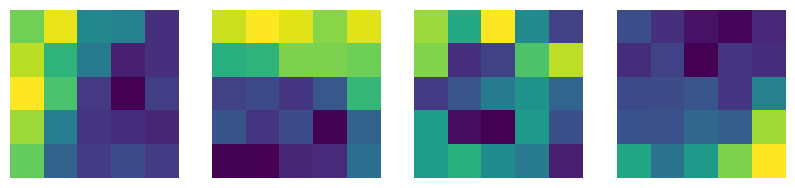

In [16]:
plt.figure(figsize = (10, 7))
for i in range(4):
    plt.subplot(1,4,i + 1)
    plt.axis('off')
    #提取第一层卷积核中的权重值，注意conv1是net的属性
    plt.imshow(net.conv1.weight.data.numpy()[i,0,...])

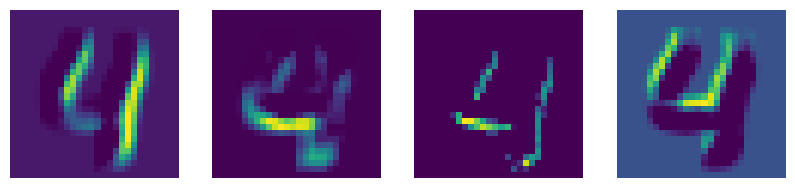

In [17]:
idx = 4
# 首先定义读入的图片
# 它是从 test_dataset 中提取第 idx 个批次的第 0 个图，其次 unsqueeze 的作用是在最前面添加一维
# 目的是为了让这个 input_x 的 tensor 是四维的，这样才能输入给 net，补充的那一维表示 batch
input_x = test_dataset[idx][0].unsqueeze(0) 

# 调用 net 的 retrieve_features 方法可以抽取出喂入当前数据后吐出来的所有特征图（第一个卷积和第二个卷积层）
feature_maps = net.retrieve_features(Variable(input_x))
# feature_maps 是有两个元素的列表，分别表示第一层和第二层卷积的所有特征图
# 所以 feature_maps[0] 就是第一层卷积的特征图

plt.figure(figsize = (10, 7))

#有四个特征图，循环把它们打印出来
for i in range(4):
    plt.subplot(1,4,i + 1)
    plt.axis('off')
    plt.imshow(feature_maps[0][0, i,...].data.numpy())

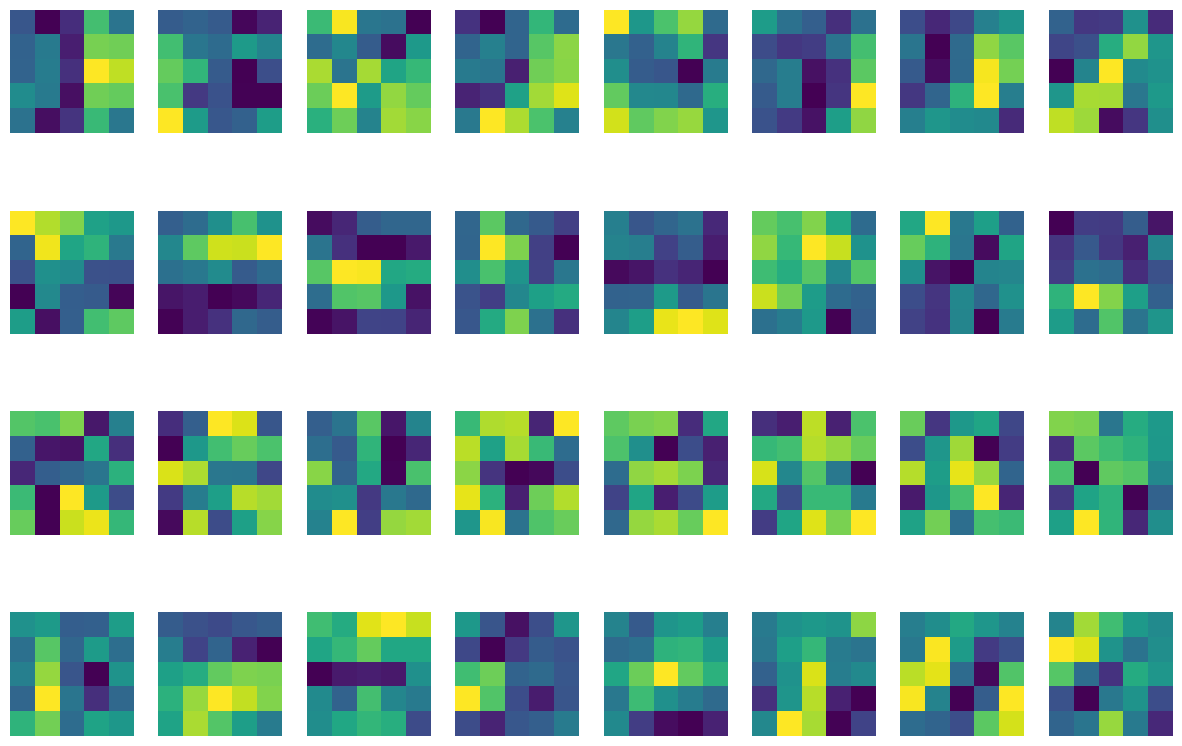

In [18]:
plt.figure(figsize = (15, 10))
for i in range(4):
    for j in range(8):
        plt.subplot(4, 8, i * 8 + j + 1)
        plt.axis('off')
        plt.imshow(net.conv2.weight.data.numpy()[j, i,...])

预测结果： tensor([4])


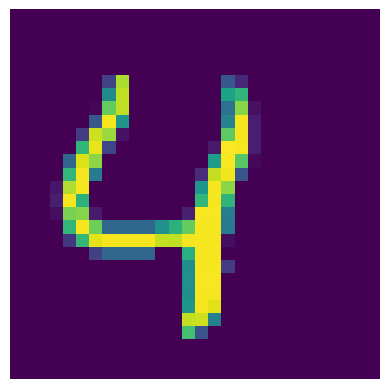

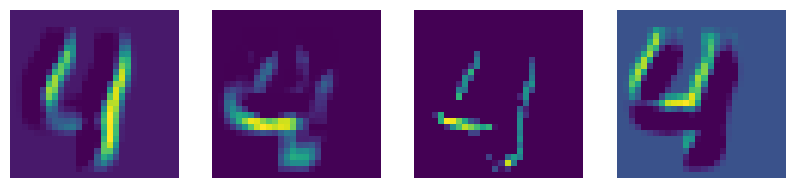

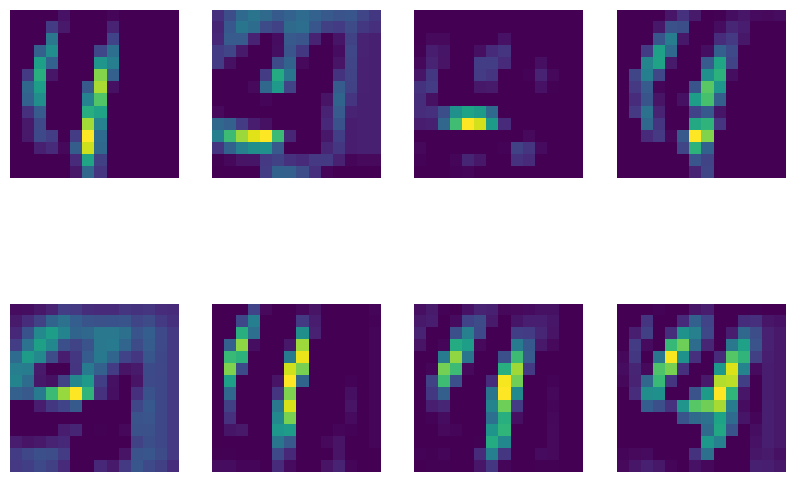

In [19]:
# 提取中test_dataset中的第idx个批次的第0个图的第0个通道对应的图像，定义为a。
a = test_dataset[idx][0][0]

# 平移后的新图像将放到b中。根据a给b赋值。
b = torch.zeros(a.size()) #全0的28*28的矩阵
w = 3 #平移的长度为3个像素

# 对于b中的任意像素i,j，它等于a中的i,j+w这个位置的像素
for i in range(a.size()[0]):
    for j in range(0, a.size()[1] - w):
        b[i, j] = a[i, j + w]

# 将b画出来
muteimg = b.numpy()
plt.axis('off')
plt.imshow(muteimg)

# 把b喂给神经网络，得到分类结果pred（prediction是预测的每一个类别的概率的对数值），并把结果打印出来
prediction = net(Variable(b.unsqueeze(0).unsqueeze(0)))
pred = torch.max(prediction.data, 1)[1]
print('预测结果：', pred)

#提取b对应的featuremap结果
feature_maps = net.retrieve_features(Variable(b.unsqueeze(0).unsqueeze(0)))

plt.figure(figsize = (10, 7))
for i in range(4):
    plt.subplot(1,4,i + 1)
    plt.axis('off')
    plt.imshow(feature_maps[0][0, i,...].data.numpy())

plt.figure(figsize = (10, 7))
for i in range(8):
    plt.subplot(2,4,i + 1)
    plt.axis('off')

    plt.imshow(feature_maps[1][0, i,...].data.numpy())